**SALES PREDICTION**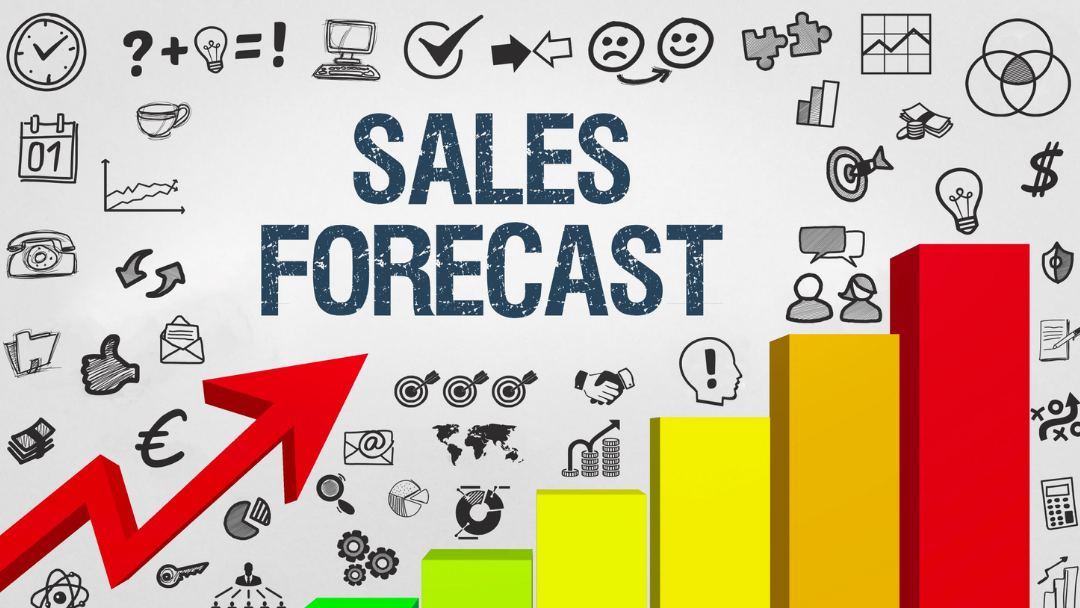

1. Importing Required Libraries and Modules

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

2. Loading the Dataset and Previewing the First Few Rows

In [21]:
try:
    data = pd.read_csv('car_purchasing.csv', encoding='utf-8')
except UnicodeDecodeError:
    data = pd.read_csv('car_purchasing.csv', encoding='latin1')

print("Initial Data Preview:")
print(data.head())

Initial Data Preview:
     customer name                                    customer e-mail  \
0    Martina Avila  cubilia.Curae.Phasellus@quisaccumsanconvallis.edu   
1    Harlan Barnes                                eu.dolor@diam.co.uk   
2  Naomi Rodriquez  vulputate.mauris.sagittis@ametconsectetueradip...   
3  Jade Cunningham                            malesuada@dignissim.com   
4     Cedric Leach     felis.ullamcorper.viverra@egetmollislectus.net   

        country  gender        age  annual Salary  credit card debt  \
0      Bulgaria       0  41.851720    62812.09301      11609.380910   
1        Belize       0  40.870623    66646.89292       9572.957136   
2       Algeria       1  43.152897    53798.55112      11160.355060   
3  Cook Islands       1  58.271369    79370.03798      14426.164850   
4        Brazil       1  57.313749    59729.15130       5358.712177   

     net worth  car purchase amount  
0  238961.2505          35321.45877  
1  530973.9078          45115.52566 

3. Checking for Missing Values and Dropping Unnecessary Columns

In [22]:
print("\nMissing Values Before Cleaning:")
print(data.isnull().sum())

data_clean = data.drop(['customer name', 'customer e-mail', 'country'], axis=1)


Missing Values Before Cleaning:
customer name          0
customer e-mail        0
country                0
gender                 0
age                    0
annual Salary          0
credit card debt       0
net worth              0
car purchase amount    0
dtype: int64


4. Outlier Detection Using Interquartile Range (IQR)

In [23]:
Q1 = data_clean.quantile(0.25)
Q3 = data_clean.quantile(0.75)
IQR = Q3 - Q1
data_clean = data_clean[~((data_clean < (Q1 - 1.5 * IQR)) | (data_clean > (Q3 + 1.5 * IQR))).any(axis=1)]


5. Feature Scaling Using StandardScaler









In [24]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_clean.drop('car purchase amount', axis=1))
scaled_data = pd.DataFrame(scaled_features, columns=data_clean.columns[:-1])


6. Visualizing Feature Correlation and 3D Scatter Plot for Feature Relationships

In [25]:
# Correlation matrix
fig = px.imshow(data_clean.corr(), title="Feature Correlation Matrix")
fig.show()

# 3D Scatter plot for feature relationships
fig = px.scatter_3d(data_clean, x='annual Salary', y='net worth', z='car purchase amount',
                    color='age', title="3D Sales Analysis")
fig.show()

7. Preparing the Data for Training and Initializing Models









In [26]:
X = scaled_data
y = data_clean['car purchase amount']

#(80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100)
xgb = XGBRegressor(n_estimators=100)


8. Performing Cross-Validation to Evaluate Model Performance









In [27]:
rf_cv_score = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
xgb_cv_score = cross_val_score(xgb, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

print("\nCross-Validation Scores (RMSE):")
print(f"Random Forest (CV RMSE): {-np.mean(rf_cv_score):.2f}")
print(f"XGBoost (CV RMSE): {-np.mean(xgb_cv_score):.2f}")


Cross-Validation Scores (RMSE):
Random Forest (CV RMSE): 5856389.94
XGBoost (CV RMSE): 5477731.69


9. Training the Models and Making Predictions









In [28]:
# Train both models
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# Predictions
rf_pred = rf.predict(X_test)
xgb_pred = xgb.predict(X_test)

10. Evaluating Model Performance Using RMSE and R² Score









In [29]:
# Evaluate models
def evaluate_model(name, pred, y_true):
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    r2 = r2_score(y_true, pred)
    print(f"{name} Performance:")
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.2f}\n")

evaluate_model("Random Forest", rf_pred, y_test)
evaluate_model("XGBoost", xgb_pred, y_test)


Random Forest Performance:
RMSE: 2250.93
R² Score: 0.94

XGBoost Performance:
RMSE: 2240.77
R² Score: 0.94



11. Visualizing Feature Importance Using Random Forest









In [30]:
fig = px.bar(x=X.columns, y=rf.feature_importances_,
             title="Feature Importance - Random Forest")
fig.show()


12. Hyperparameter Tuning for Random Forest Using GridSearchCV









In [31]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [32]:
# Best model from grid search
best_model = grid_search.best_estimator_
best_pred = best_model.predict(X_test)

# Evaluate tuned model
evaluate_model("Tuned Random Forest", best_pred, y_test)

Tuned Random Forest Performance:
RMSE: 2246.21
R² Score: 0.94



13. Hyperparameter Tuning for XGBoost Using GridSearchCV









In [19]:
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3]
}

grid_search_xgb = GridSearchCV(XGBRegressor(), param_grid_xgb, cv=5, scoring='neg_mean_squared_error')
grid_search_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [20]:
# Best XGBoost model
best_xgb_model = grid_search_xgb.best_estimator_
best_xgb_pred = best_xgb_model.predict(X_test)

# Evaluate tuned XGBoost model
evaluate_model("Tuned XGBoost", best_xgb_pred, y_test)

Tuned XGBoost Performance:
RMSE: 1526.28
R² Score: 0.97

